# Time series forecasting project

In [63]:
# Handle imports up-front
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from pmdarima import auto_arima

## 1. Data loading

### 1.1. Load

In [64]:
if dataset == 'flights':
    raw_data_df=sns.load_dataset("flights")

elif dataset == 'sales':
    raw_data_df=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv')


In [65]:
print(timeseries_df.head())
print(timeseries_df.info())


            dependent_var  x  baseline_pred  dependent_var_diff
date                                                           
1949-01-01            112  0      90.309962                 NaN
1949-02-01            118  1      92.967146                 6.0
1949-03-01            132  2      95.624330                14.0
1949-04-01            129  3      98.281513                -3.0
1949-05-01            121  4     100.938697                -8.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   dependent_var       144 non-null    int64  
 1   x                   144 non-null    int64  
 2   baseline_pred       144 non-null    float64
 3   dependent_var_diff  143 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 5.6 KB
None


### 1.2. Inspect 

In [66]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


### 1.3. Encode date feature

Pandas has many great tools to work with timeseries data - see the user guide article: '*[Time series / date functionality](https://pandas.pydata.org/docs/user_guide/timeseries.html)*'. First thing to do is convert our string date feature(s) to a Datetime object.

In [67]:
# Make a copy of the raw data to work with
timeseries_df=raw_data_df.copy()

# Extract the string month to a datetime object feature
timeseries_df['month']=pd.to_datetime(raw_data_df.month, format='%b').dt.month

# Use the month and year to create at 'date' datetime feature
timeseries_df['date']=pd.to_datetime(timeseries_df[['year', 'month']].assign(day=1))

# Set the datetime feature as the index
timeseries_df=timeseries_df.set_index('date')

# Keep only the passenger column
timeseries_df.drop(['year', 'month'], axis=1, inplace=True)

# Re-name 'passengers' to 'dependent_var' so we can easily swap datasets without making
# changes to the notebook
timeseries_df.rename(columns={'passengers': 'dependent_var'}, inplace=True)

# Check the result
timeseries_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   dependent_var  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


## 2. EDA

### 2.1. Baseline model performance

Let's set a quick performance baseline using a quick/easy linear regression model.

In [68]:
# Create a numeric range for the feature variable 'x'
timeseries_df['x'] = np.arange(len(timeseries_df))

# Define the feature (x) and target variable (y)
X = timeseries_df[['x']]
y = timeseries_df['dependent_var']

# Split the dataset into training and testing sets
ts_split = TimeSeriesSplit(n_splits=3)
for train_index, test_index in ts_split.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit a simple linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)

    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Squared Error (MSE): 962.58
Root Mean Squared Error (RMSE): 31.03
Mean Squared Error (MSE): 3766.91
Root Mean Squared Error (RMSE): 61.38
Mean Squared Error (MSE): 4989.60
Root Mean Squared Error (RMSE): 70.64


### 2.2. Missing, and/or extreme values

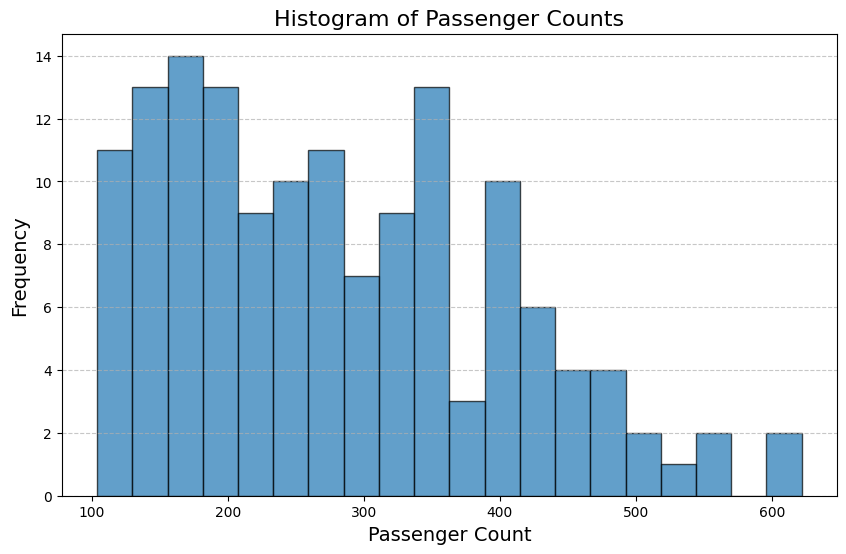

In [69]:
# Plot a histogram for the dependent variable
plt.figure(figsize=(10, 6))
plt.hist(timeseries_df['dependent_var'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of Passenger Counts', fontsize=16)
plt.xlabel('Passenger Count', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### 2.3. Timeseries analysis

Let's now take a look at the data as a timeseries. There are a couple of things to look out for here.

1. Is the time axis regular - i.e. are the rows evenly spaced in time.
2. Is the data stationary - i.e. is there a consistent trend over time. The answer to this question will effect how we model the data.
3. Are there regular or cyclical trends - e.g. sales are high on Mondays and low on weekends.

Unique time differences:
<TimedeltaArray>
['31 days', '28 days', '30 days', '29 days']
Length: 4, dtype: timedelta64[ns]



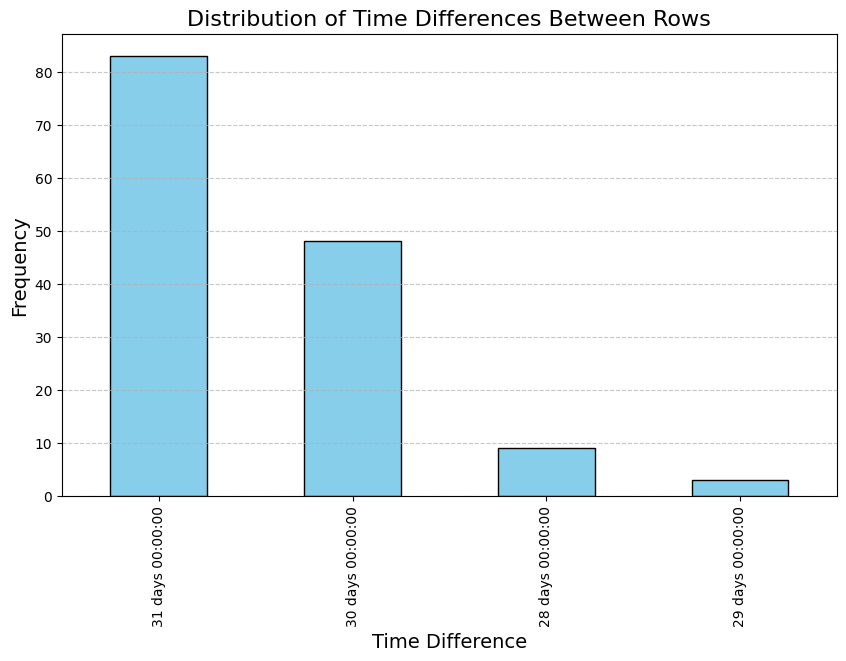

In [70]:
# Check if the time axis is regular
time_diffs = timeseries_df.index.to_series().diff().dropna()

# Print the unique time differences
print(f"Unique time differences:\n{time_diffs.unique()}\n")

# Plot the time differences to visually inspect
plt.figure(figsize=(10, 6))
time_diffs.value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Time Differences Between Rows', fontsize=16)
plt.xlabel('Time Difference', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [71]:
from statsmodels.tsa.stattools import adfuller

dftest=adfuller(timeseries_df['dependent_var'], autolag = "AIC")
print(f'Dicky-Fuller p-value: {dftest[1]:.3f}')

Dicky-Fuller p-value: 0.992


<Figure size 1200x1000 with 0 Axes>

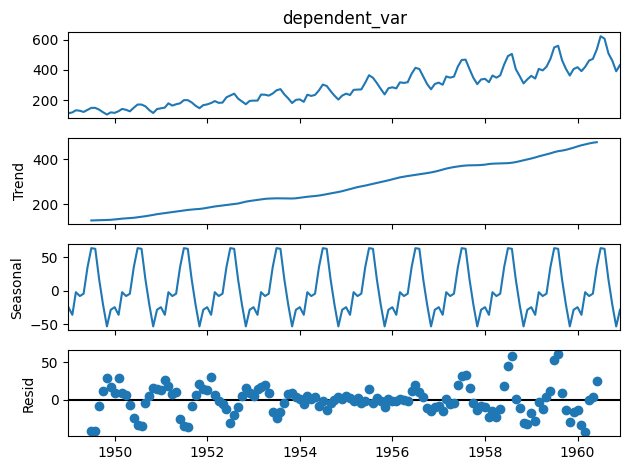

In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(timeseries_df['dependent_var'], model='additive', period=12)

# Plot the decomposition
plt.figure(figsize=(12, 10))
decomposition.plot()
plt.show()


### 2.3.1. Plot the time-series

Let's include predictions from the baseline model too and see what we are working with.

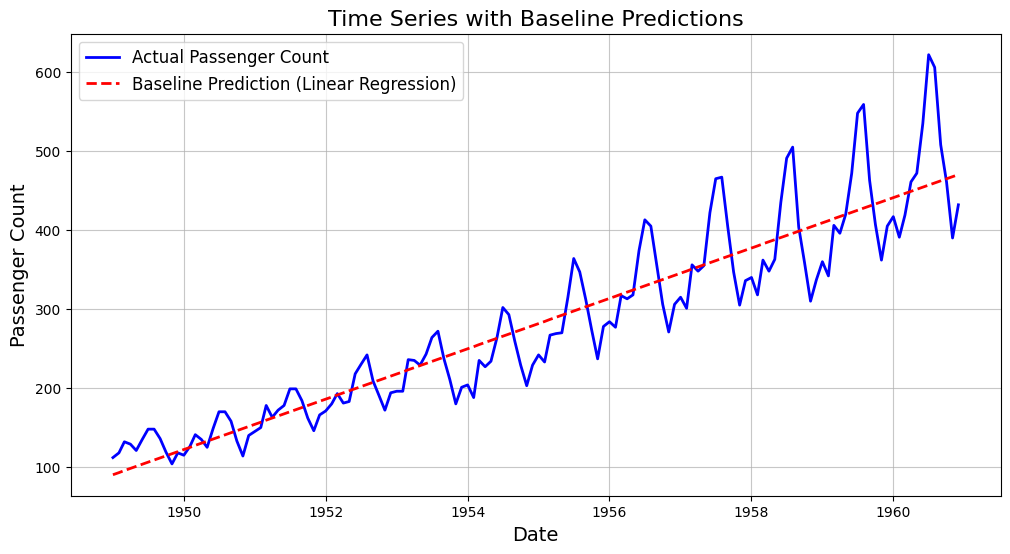

In [74]:
# Predict on the entire dataset for simplicity
X_full = timeseries_df[['x']]
y_full = timeseries_df['dependent_var']

# Fit the linear regression model
baseline_model = LinearRegression()
baseline_model.fit(X_full, y_full)

# Generate predictions
timeseries_df['baseline_pred'] = baseline_model.predict(X_full)

# Plot the actual data and the baseline predictions
plt.figure(figsize=(12, 6))
plt.plot(timeseries_df.index, timeseries_df['dependent_var'], label='Actual Passenger Count', color='blue', linewidth=2)
plt.plot(timeseries_df.index, timeseries_df['baseline_pred'], label='Baseline Prediction (Linear Regression)', color='red', linestyle='--', linewidth=2)
plt.title('Time Series with Baseline Predictions', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Passenger Count', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.7)
plt.show()


### 2.3.2. Missing timepoints

Next, do a quick check to see if the datetime index we just created is evenly spaced - i.e. the time delta between the rows is always the same.

Unique time differences:
<TimedeltaArray>
['31 days', '28 days', '30 days', '29 days']
Length: 4, dtype: timedelta64[ns]


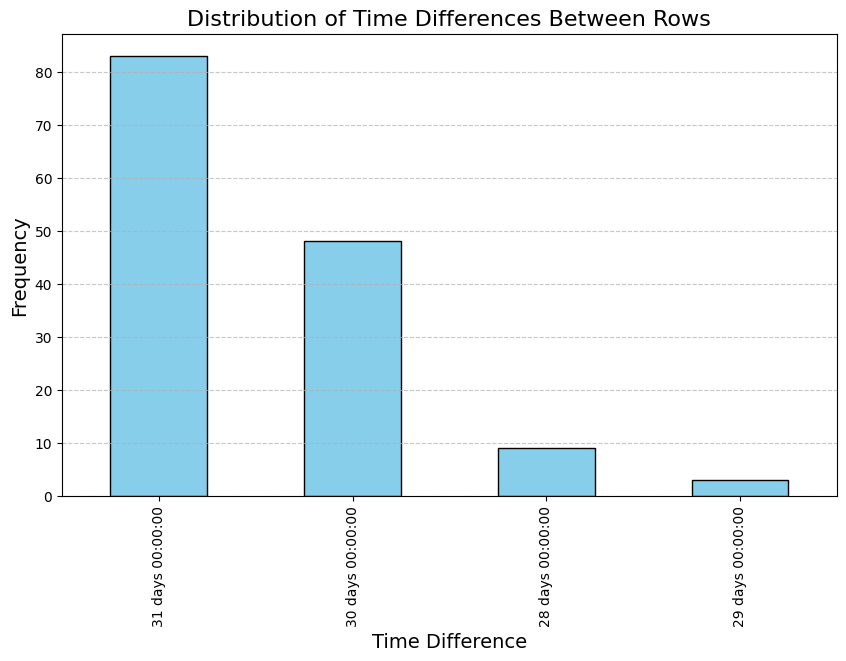

Original data length: 144
Resampled data length: 144
The datetime index is evenly spaced.


In [75]:
# Check the time delta between consecutive rows
time_diffs = timeseries_df.index.to_series().diff().dropna()

# Print unique time differences
print("Unique time differences:")
print(time_diffs.unique())

# Plot the time differences
plt.figure(figsize=(10, 6))
time_diffs.value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Time Differences Between Rows', fontsize=16)
plt.xlabel('Time Difference', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Use resample to check regularity
resampled = timeseries_df['dependent_var'].resample('MS').mean()  # 'MS' stands for Month Start

# Compare the original index with the resampled index
print(f"Original data length: {len(timeseries_df)}")
print(f"Resampled data length: {len(resampled)}")

if len(timeseries_df) == len(resampled):
    print("The datetime index is evenly spaced.")
else:
    print("The datetime index is NOT evenly spaced.")


### 2.3.3. Stationarity

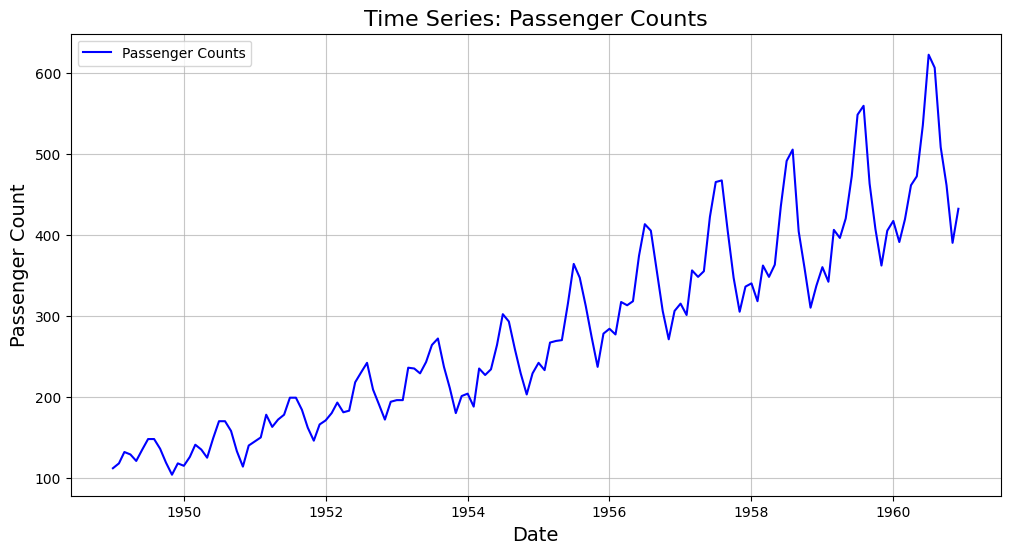

Augmented Dickey-Fuller Test Results:
ADF Statistic: 0.8154
p-value: 0.9919
Critical Values:
  1%: -3.4817
  5%: -2.8840
  10%: -2.5788

The time series is NOT stationary (fail to reject the null hypothesis).


In [76]:
# from statsmodels.tsa.stattools import adfuller

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(timeseries_df['dependent_var'], label='Passenger Counts', color='blue')
plt.title('Time Series: Passenger Counts', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Passenger Count', fontsize=14)
plt.legend()
plt.grid(alpha=0.7)
plt.show()

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(timeseries_df['dependent_var'])

# Print the results
print("Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.4f}")

# Interpretation
if adf_result[1] < 0.05:
    print("\nThe time series is stationary (reject the null hypothesis).")
else:
    print("\nThe time series is NOT stationary (fail to reject the null hypothesis).")


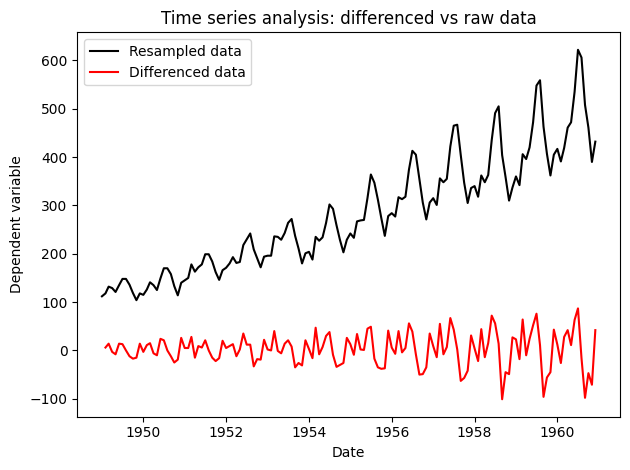

In [77]:
stationary_timeseries_df=timeseries_df['dependent_var'].diff().dropna()

plt.title('Time series analysis: differenced vs raw data')
plt.plot(timeseries_df.index, timeseries_df['dependent_var'], label='Resampled data', color='black')
plt.plot(stationary_timeseries_df.index, stationary_timeseries_df, label='Differenced data', color='red')
plt.xlabel('Date')
plt.ylabel('Dependent variable')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### 2.3.4. Seasonality

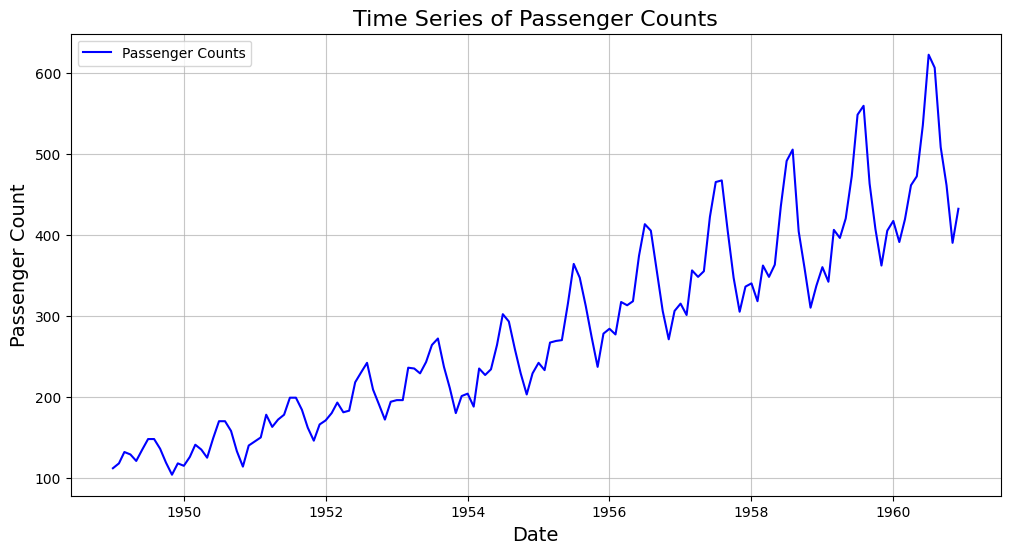

In [78]:
# Plot the time series to observe seasonality
plt.figure(figsize=(12, 6))
plt.plot(timeseries_df['dependent_var'], label='Passenger Counts', color='blue')
plt.title('Time Series of Passenger Counts', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Passenger Count', fontsize=14)
plt.legend()
plt.grid(alpha=0.7)
plt.show()


## 3. Model training

In [85]:
timeseries_model=auto_arima(timeseries_df['dependent_var'], seasonal=True, stationary=False, trace=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1020.048, Time=1.09 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.21 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1019.935, Time=0.55 sec


 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1019.290, Time=0.21 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1019.546, Time=0.64 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1024.160, Time=0.13 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1017.847, Time=0.17 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1017.914, Time=0.49 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1018.359, Time=0.43 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1018.248, Time=0.92 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.08 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1022.393, Time=0.05 sec
 ARIMA(3,1,1)(0,1,0)[12]             : AIC=1019.084, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.04 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=1023.666, Time=0.06 sec
 ARIMA(3,1,2)(0,1,0)[12]             : AIC=1021.083, Time=0.62 sec
 ARIMA(2,1,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.43 sec

Best model:  ARIMA(2,1,1)(0,1,0)[12]          
Total fit time: 6.4

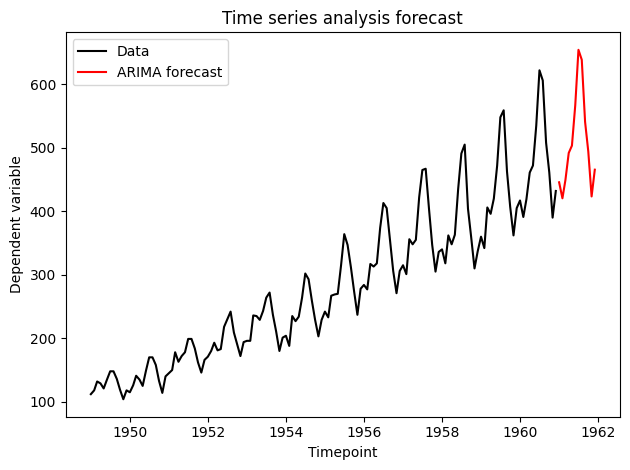

In [86]:
# Make predictions for the next 12 timepoints into the future
forecast=timeseries_model.predict(12)

plt.title('Time series analysis forecast')
plt.plot(timeseries_df['dependent_var'], label='Data', color='black')
plt.plot(forecast, label='ARIMA forecast', color='red')
plt.xlabel('Timepoint')
plt.ylabel('Dependent variable')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## 4. Model evaluation

This result *looks* convincing, at least if you don't look too close - but how well are we actualy doing? We need to implement test-train splitting and/or cross-validation to estimate the actual performance on unseen data!

Breaking up time-series data is a little bit harder than other types of tabular data - we can't just randomly select data points for the training and/or validation sets becuase the order matters!

Luckily, Scikit-learn can help us out here - take a look at [TimeSeriesSplit](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

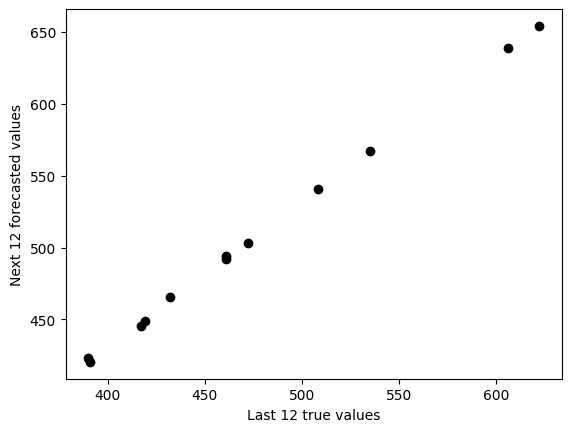

In [87]:
# Get the last 12 timepoints from the real data
true_data=timeseries_df['dependent_var'][-12:]

# Plot them against the predictions
plt.scatter(true_data, forecast, color='black')
plt.xlabel('Last 12 true values')
plt.ylabel('Next 12 forecasted values')
plt.show()

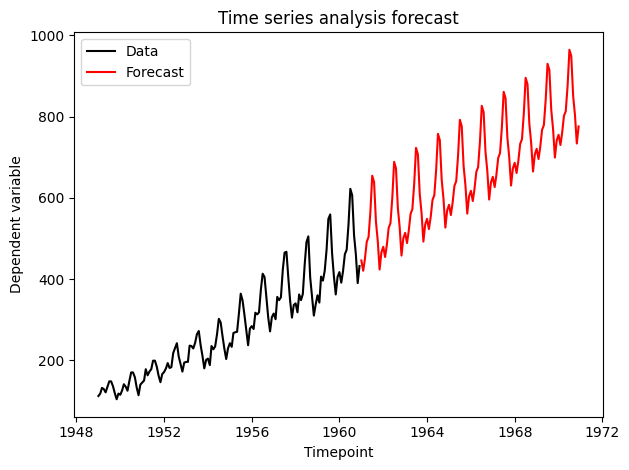

In [88]:
# Make predictions for the next 120 timepoints into the future
forecast=timeseries_model.predict(120)

plt.title('Time series analysis forecast')
plt.plot(timeseries_df['dependent_var'], label='Data', color='black')
plt.plot(forecast, label='Forecast', color='red')
plt.xlabel('Timepoint')
plt.ylabel('Dependent variable')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [89]:
# Set a forecast horizon, i.e. how far into the future, we want to predict
forecast_horizon=6

# Set a model order, i.e. how many past datapoints should be used as input for prediction
model_order=36

In [95]:
# Make the test set one forecast horizon in length
testing_dataset_size=forecast_horizon

# Calculate how long the training set needs to be
training_set_size=len(timeseries_df) - testing_dataset_size

# Get the training and testing sets
training_data=timeseries_df[:training_set_size]
testing_data=timeseries_df[training_set_size:]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=175.578, Time=0.57 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=182.289, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=175.209, Time=0.16 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=179.585, Time=0.08 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=252.333, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=173.687, Time=0.06 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=175.213, Time=0.16 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=177.215, Time=0.15 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=174.616, Time=0.14 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=175.058, Time=0.08 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=177.710, Time=0.04 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=176.576, Time=0.19 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=178.963, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,1,0)[12] intercept
Total fit time: 1.703 seconds
Performing stepwise s

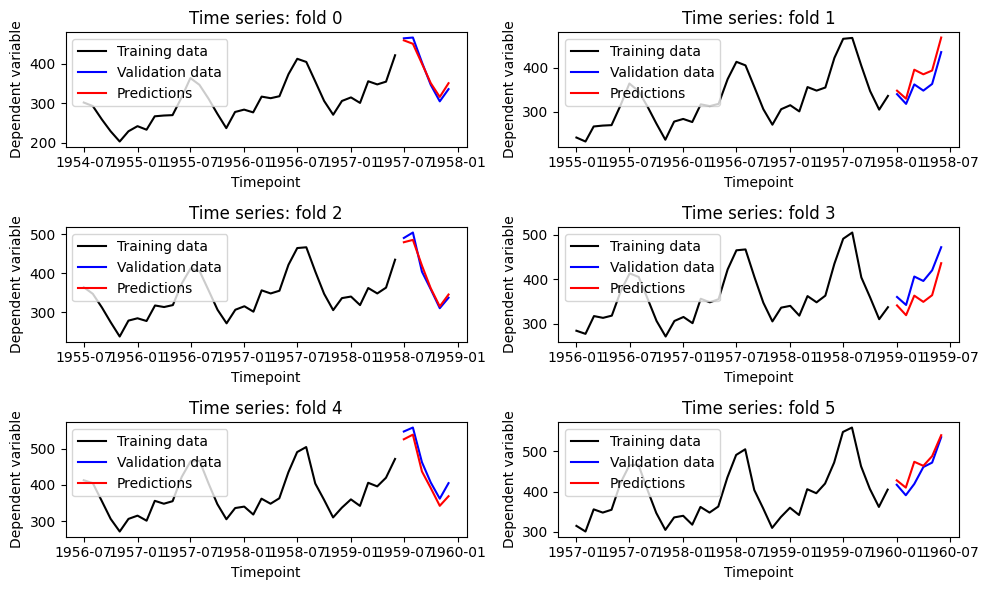

In [96]:
# Number of 'cross-validation' folds to run
folds=6

# Holders to collect data for later
validation_rmse_values=[]
predicted_values=[]
validation_values=[]

# Set-up a multiplot for the results
fig, axs=plt.subplots(3, 2, figsize=(10,6))
axs=axs.flatten()

# Instantiate a time series splitter
timeseries_splits=TimeSeriesSplit(n_splits=folds, max_train_size=model_order, test_size=forecast_horizon)

# Loop on the splits with a counter
for i, timeseries_split in enumerate(timeseries_splits.split(training_data)):

    # Recover the split indicies
    training_indicies=timeseries_split[0]
    validation_indicies=timeseries_split[1]

    # Get the data for this split from the training data
    fold_training_data=training_data.iloc[training_indicies, :]
    fold_validation_data=training_data.iloc[validation_indicies, :]

    # Fit the model and predict out to the forecast horizon
    timeseries_model=auto_arima(fold_training_data['dependent_var'], stationary=False, trace=True, seasonal=True, m=12, suppress_warnings=True)
    forecast=timeseries_model.predict(forecast_horizon)

    # Collect intermediate results
    predicted_values.extend(forecast)
    validation_values.extend(fold_validation_data['dependent_var'])

    rmse=sqrt(mean_squared_error(fold_validation_data['dependent_var'], forecast))
    validation_rmse_values.append(rmse)

    # Draw the timeseries plot for this fold
    axs[i].set_title(f'Time series: fold {i}')
    axs[i].plot(fold_training_data['dependent_var'], label='Training data', color='black')
    axs[i].plot(fold_validation_data['dependent_var'], label='Validation data', color='blue')
    axs[i].plot(forecast, label='Predictions', color='red')
    axs[i].set_xlabel('Timepoint')
    axs[i].set_ylabel('Dependent variable')
    axs[i].legend(loc='best')

plt.tight_layout()
plt.show()

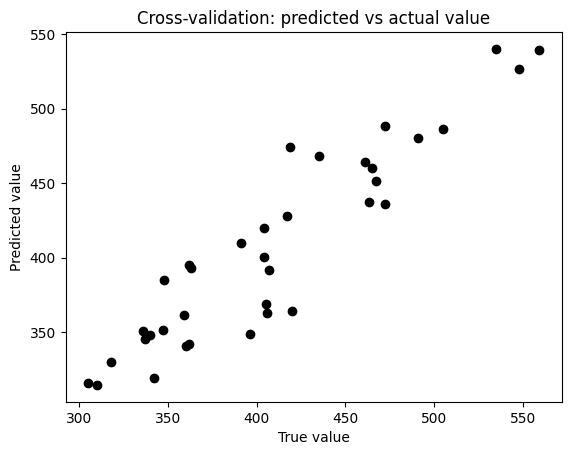

In [97]:
# Plot the forcasted values against the true values
plt.title('Cross-validation: predicted vs actual value')
plt.scatter(validation_values, predicted_values, color='black')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.show()

In [102]:
# Initialize a dictionary to store RMSE results
rmse_results = {}

# Assuming `validation_rmse_values` is a list of RMSE values obtained from cross-validation
validation_rmse_values = rmse_scores  # Replace with the actual variable storing your RMSE values if different

# Compute mean and standard deviation of RMSE values
mean_rmse = np.mean(validation_rmse_values)
std_rmse = np.std(validation_rmse_values)

# Print the cross-validation RMSE results
print(f'Cross-validation RMSE: {mean_rmse:.1f} +/- {std_rmse:.1f}')

# Store the results in the dictionary
rmse_results['ARIMA cross-validation mean'] = mean_rmse
rmse_results['ARIMA cross-validation std'] = std_rmse

# Display the RMSE results dictionary
print(rmse_results)


Cross-validation RMSE: 54.3 +/- 16.9
{'ARIMA cross-validation mean': 54.34589387578334, 'ARIMA cross-validation std': 16.91798415324107}


In [99]:
timeseries_model=auto_arima(training_data['dependent_var'], stationary=False, seasonal=True, trace=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=968.112, Time=0.92 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=979.631, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=968.498, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=969.489, Time=0.15 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=968.009, Time=0.44 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=967.105, Time=0.16 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=967.743, Time=0.44 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=971.233, Time=0.07 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=971.406, Time=0.13 sec
 ARIMA(3,1,2)(0,1,0)[12]             : AIC=967.253, Time=0.32 sec
 ARIMA(2,1,3)(0,1,0)[12]             : AIC=967.525, Time=0.24 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=969.506, Time=0.05 sec
 ARIMA(1,1,3)(0,1,0)[12]             : AIC=967.001, Time=0.14 sec
 ARIMA(1,1,3)(1,1,0)[12]             : AIC=967.503, Time=0.31 sec
 ARIMA(1,1,3)(0,1,1)[12]         

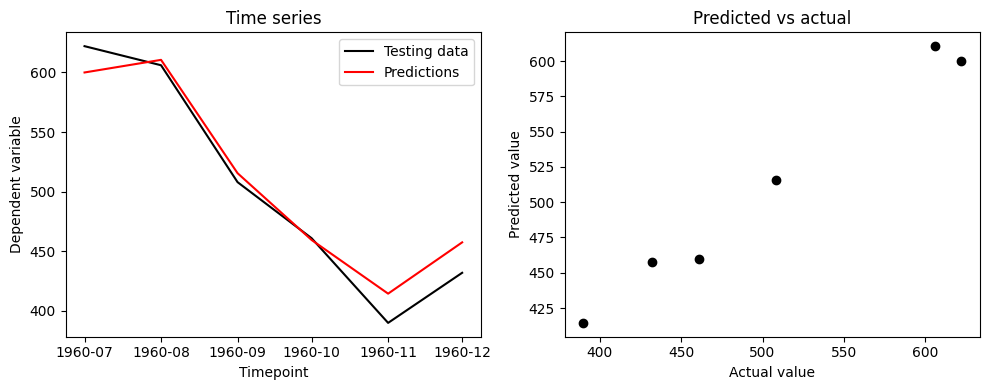

In [100]:
# Make predictions
forecast=timeseries_model.predict(forecast_horizon)

# Plot the result
fig, (ax1, ax2)=plt.subplots(1,2, figsize=(10,4))

ax1.set_title('Time series')
ax1.plot(testing_data['dependent_var'], label='Testing data', color='black')
ax1.plot(forecast, label='Predictions', color='red')
ax1.set_xlabel('Timepoint')
ax1.set_ylabel('Dependent variable')
ax1.legend(loc='best')

ax2.set_title('Predicted vs actual')
ax2.scatter(testing_data['dependent_var'], forecast, color='black')
ax2.set_xlabel('Actual value')
ax2.set_ylabel('Predicted value')

plt.tight_layout()
plt.show()

In [103]:
# Calculate RMSE on test set
rmse=sqrt(mean_squared_error(testing_data['dependent_var'], forecast))
rmse_results['ARIMA test data']=rmse

print(f'Root mean square error:')

for experiment, rmse in rmse_results.items():
    print(f'  {experiment}: {rmse:.1f}')

Root mean square error:
  ARIMA cross-validation mean: 54.3
  ARIMA cross-validation std: 16.9
  ARIMA test data: 17.4


Honestly had a really rough time with this one. 